In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import math
from math import log, log2
from scipy.stats import zscore

In [2]:
dataframe = pd.read_csv('preprocessedData.csv', index_col = 'ReadingDateTime', parse_dates = True)
dataframe

,BP,NO,NO2,NOX,SO2,SOLR,WDIR,WSPD
ReadingDateTime,,,,,,,,
2014-01-01 00:00:00,997.0,0.1,15.1,15.2,2.4,0.0,187.0,4.9
2014-01-01 00:15:00,997.0,0.1,15.1,15.2,2.4,0.0,187.0,4.9
2014-01-01 00:30:00,997.0,0.1,15.1,15.2,2.4,0.0,192.0,3.5
2014-01-01 00:45:00,997.0,0.1,15.1,15.2,2.4,0.0,209.0,3.5
2014-01-01 01:00:00,997.0,0.1,15.1,15.2,2.4,0.0,203.0,3.2
...,...,...,...,...,...,...,...,...
2018-12-31 22:45:00,1029.0,0.0,3.9,3.9,2.3,5.0,282.0,0.2
2018-12-31 23:00:00,1029.0,0.0,3.9,3.9,2.3,5.0,282.0,0.2
2018-12-31 23:15:00,1029.0,0.0,3.9,3.9,2.3,5.0,272.0,0.2


In [3]:
def shiftFiveReadings(dataframe, name):
    data = dataframe.copy()
    newColumn1 = name + "_Previous_1st_Reading"
    data[newColumn1] = dataframe[name].shift(+1)
      
    newColumn2 = name + "_Previous_2nd_Reading"
    data[newColumn2] = dataframe[name].shift(+2)
        
    newColumn3 = name + "_Previous_3rd_Reading"
    data[newColumn3] = dataframe[name].shift(+3)
        
    newColumn4 = name + "_Previous_4th_Reading"
    data[newColumn4] = dataframe[name].shift(+4)
       
    newColumn5 = name + "_Previous_5th_Reading"
    data[newColumn5] = dataframe[name].shift(+5)
    return data

In [4]:
dataframeA = shiftFiveReadings(dataframe, 'NO2')
dataframeA.interpolate(method = 'linear', axis = 0, limit_direction = 'both', inplace = True)
features = dataframeA[dataframeA.columns.difference(['NO2'])]
dataframeA['NO2'] = zscore(dataframeA['NO2'])

In [5]:
bin = [0 for _ in range(dataframeA.shape[0])]

def equalWidthBinning(dataframe):
    for index in range(dataframe.shape[0]):
        value = dataframe['NO2'][index]
        if value >= -3 and value < -2:
            bin[index] = 0
        elif value >= -2 and value < -1 :
            bin[index] = 1
        elif value >= -1 and value < 0:
            bin[index] = 2
        elif value >= 0 and value < 1:
            bin[index] = 3
        elif value >= 1 and value < 2: 
            bin[index] = 4
        elif value >= 2 and value < 3:
            bin[index] = 5
        else:
            pass
    return bin

In [6]:
dataframeA['Bin'] = equalWidthBinning(dataframeA)
dataframeA

,BP,NO,NO2,NOX,SO2,SOLR,WDIR,WSPD,NO2_Previous_1st_Reading,NO2_Previous_2nd_Reading,NO2_Previous_3rd_Reading,NO2_Previous_4th_Reading,NO2_Previous_5th_Reading,Bin
ReadingDateTime,,,,,,,,,,,,,,
2014-01-01 00:00:00,997.0,0.1,-0.465748,15.2,2.4,0.0,187.0,4.9,15.1,15.1,15.1,15.1,15.1,2
2014-01-01 00:15:00,997.0,0.1,-0.465748,15.2,2.4,0.0,187.0,4.9,15.1,15.1,15.1,15.1,15.1,2
2014-01-01 00:30:00,997.0,0.1,-0.465748,15.2,2.4,0.0,192.0,3.5,15.1,15.1,15.1,15.1,15.1,2
2014-01-01 00:45:00,997.0,0.1,-0.465748,15.2,2.4,0.0,209.0,3.5,15.1,15.1,15.1,15.1,15.1,2
2014-01-01 01:00:00,997.0,0.1,-0.465748,15.2,2.4,0.0,203.0,3.2,15.1,15.1,15.1,15.1,15.1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 22:45:00,1029.0,0.0,-1.270160,3.9,2.3,5.0,282.0,0.2,3.9,3.9,3.9,3.9,3.9,1
2018-12-31 23:00:00,1029.0,0.0,-1.270160,3.9,2.3,5.0,282.0,0.2,3.9,3.9,3.9,3.9,3.9,1
2018-12-31 23:15:00,1029.0,0.0,-1.270160,3.9,2.3,5.0,272.0,0.2,3.9,3.9,3.9,3.9,3.9,1


In [7]:
dataframeA['Bin'].value_counts()

2    75901
3    41033
1    23701
4    17688
5    10961
Name: Bin, dtype: int64

In [8]:
def infoGain(features, target, attribute):
    classSet = set()
    classMap = {}
    totalSize = target.size
    data = np.array(features[attribute])
    entropy = 0 
    count = []
    index = 0
    for i in target:
        if(i not in classSet):
            classSet.add(i)
            classMap[i] = index
            count.append(1)
            index += 1
        else:
            count[classMap[i]] += 1
    
    for i in count:
        p = (i / totalSize)
        entropy += p*log2(p)
    
    attributeSet = set() 
    attributeMap = {} 
    attributeCount = []
    attributeIndex = 0
    
    for j in data:
        if(j not in attributeSet):
            attributeSet.add(j)
            attributeMap[j] = attributeIndex
            attributeCount.append(1)
            attributeIndex += 1
        else:
            attributeCount[attributeMap[j]] += 1 
        
    cc_a = [0 for i in range(len(attributeSet) * len(classSet))]
    class_counter_a = np.reshape(cc_a, (len(attributeSet), len(classSet)))
    
    for j in range(data.shape[0]):
        class_counter_a[attributeMap[data[j]]][classMap[target[j]]]+=1

    
    entropy_a=0
    for y in range(len(attributeSet)):
        summation = 0;
        entropy_b = 0
        for z in range(len(classSet)):
            summation += class_counter_a[y][z]
            
        for z in range(len(classSet)):
            p = class_counter_a[y][z] / summation     
            if p!=0:
                entropy_b += p * log2(p)
        entropy_b *= (attributeCount[y]/totalSize)
        entropy_a += entropy_b
    return entropy_a - entropy

In [9]:
informationGain = {}
attributes = ['BP', 'NO', 'NOX', 'SO2', 'SOLR', 'WDIR', 'WSPD', 'NO2_Previous_1st_Reading', 'NO2_Previous_2nd_Reading', 'NO2_Previous_3rd_Reading', 'NO2_Previous_4th_Reading', 'NO2_Previous_5th_Reading']
for attribute in attributes:
    informationGain[attribute] = infoGain(features, dataframeA['Bin'], attribute)
informationGain

{'BP': 0.09224292028694481,
 'NO': 0.6184063224183509,
 'NOX': 1.5180608100047661,
 'SO2': 0.19388681668862406,
 'SOLR': 0.23378763713632789,
 'WDIR': 0.1251064674437523,
 'WSPD': 0.2030805113391123,
 'NO2_Previous_1st_Reading': 1.5388474680941417,
 'NO2_Previous_2nd_Reading': 1.3376858185995548,
 'NO2_Previous_3rd_Reading': 1.199198449053839,
 'NO2_Previous_4th_Reading': 1.0901846844424052,
 'NO2_Previous_5th_Reading': 1.0020292466284002}

In [10]:
features = dataframeA[dataframeA.columns.difference(['NO2', 'Bin'])]
output = dataframeA['NO2']
training_features, testing_features, training_output, testing_output = train_test_split(features, output, test_size = 0.30)

In [11]:
training_features.columns

Index(['BP', 'NO', 'NO2_Previous_1st_Reading', 'NO2_Previous_2nd_Reading',
       'NO2_Previous_3rd_Reading', 'NO2_Previous_4th_Reading',
       'NO2_Previous_5th_Reading', 'NOX', 'SO2', 'SOLR', 'WDIR', 'WSPD'],
      dtype='object')

In [12]:
weights = []
for column in training_features.columns:
    weights.append(informationGain[column])
print(weights)

[0.09224292028694481, 0.6184063224183509, 1.5388474680941417, 1.3376858185995548, 1.199198449053839, 1.0901846844424052, 1.0020292466284002, 1.5180608100047661, 0.19388681668862406, 0.23378763713632789, 0.1251064674437523, 0.2030805113391123]


In [13]:
def weightedDistance(vectorA, vectorB):
    return np.sqrt(np.sum(np.square(np.subtract(np.multiply(weights, vectorA), np.multiply(weights, vectorB)))))

In [14]:
knnRegressor = neighbors.KNeighborsRegressor(n_jobs = -1, n_neighbors = 11, metric = weightedDistance)
knnRegressor.fit(training_features, training_output)

KNeighborsRegressor(metric=<function weightedDistance at 0x0000014A2F796A60>,
                    n_jobs=-1, n_neighbors=11)

In [15]:
start = time.time()

prediction = pd.Series(knnRegressor.predict(testing_features[0 : 500]), index = testing_features.index[0 : 500]).astype('float64')
print("1st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[500 : 1000]), index = testing_features.index[500 : 1000])])
print("2nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[1000 : 1500]), index = testing_features.index[1000 : 1500])])
print("3rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[1500 : 2000]), index = testing_features.index[1500 : 2000])])
print("4th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[2000 : 2500]), index = testing_features.index[2000 : 2500])])
print("5th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[2500 : 3000]), index = testing_features.index[2500 : 3000])])
print("6th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[3000 : 3500]), index = testing_features.index[3000 : 3500])])
print("7th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[3500 : 4000]), index = testing_features.index[3500 : 4000])])
print("8th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[4000 : 4500]), index = testing_features.index[4000 : 4500])])
print("9th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[4500 : 5000]), index = testing_features.index[4500 : 5000])])
print("10th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[5000 : 5500]), index = testing_features.index[5000 : 5500])])
print("11th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[5500 : 6000]), index = testing_features.index[5500 : 6000])])
print("12th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[6000 : 6500]), index = testing_features.index[6000 : 6500])])
print("13th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[6500 : 7000]), index = testing_features.index[6500 : 7000])])
print("14th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[7000 : 7500]), index = testing_features.index[7000 : 7500])])
print("15th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[7500 : 8000]), index = testing_features.index[7500 : 8000])])
print("16th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[8000 : 8500]), index = testing_features.index[8000 : 8500])])
print("17th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[8500 : 9000]), index = testing_features.index[8500 : 9000])])
print("18th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[9000 : 9500]), index = testing_features.index[9000 : 9500])])
print("19th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[9500 : 10000]), index = testing_features.index[9500 : 10000])])
print("20th iteration - ", time.time())

print(prediction)

1st iteration -  1652268062.2003207
2nd iteration -  1652268590.3432312
3rd iteration -  1652269125.765036
4th iteration -  1652269632.6081877
5th iteration -  1652270146.6088624
6th iteration -  1652270654.7398007
7th iteration -  1652271183.236885
8th iteration -  1652271578.8235025
9th iteration -  1652271973.8634968
10th iteration -  1652272354.0032728
11th iteration -  1652272747.0193443
12th iteration -  1652273147.1788304
13th iteration -  1652273545.8898985
14th iteration -  1652273941.862407
15th iteration -  1652274398.202872
16th iteration -  1652275833.3051903
17th iteration -  1652277311.0173082
18th iteration -  1652278687.1608443
19th iteration -  1652279196.704249
20th iteration -  1652279689.4554868
ReadingDateTime
2014-08-14 12:00:00   -0.252239
2014-11-26 10:30:00    1.150911
2016-03-19 06:15:00   -0.581970
2015-03-24 14:45:00   -0.773279
2014-06-15 14:30:00   -0.893478
                         ...   
2018-11-03 15:15:00    0.830975
2015-12-20 22:00:00   -0.994655
20

In [16]:
prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[10000 : 10500]), index = testing_features.index[10000 : 10500])])
print("21st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[10500 : 11000]), index = testing_features.index[10500 : 11000])])
print("22nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[11000 : 11500]), index = testing_features.index[11000 : 11500])])
print("23rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[11500 : 12000]), index = testing_features.index[11500 : 12000])])
print("24th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[12000 : 12500]), index = testing_features.index[12000 : 12500])])
print("25th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[12500 : 13000]), index = testing_features.index[12500 : 13000])])
print("26th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[13000 : 13500]), index = testing_features.index[13000 : 13500])])
print("27th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[13500 : 14000]), index = testing_features.index[13500 : 14000])])
print("28th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[14000 : 14500]), index = testing_features.index[14000 : 14500])])
print("29th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[14500 : 15000]), index = testing_features.index[14500 : 15000])])
print("30th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[15000 : 15500]), index = testing_features.index[15000 : 15500])])
print("31st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[15500 : 16000]), index = testing_features.index[15500 : 16000])])
print("32nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[16000 : 16500]), index = testing_features.index[16000 : 16500])])
print("33rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[16500 : 17000]), index = testing_features.index[16500 : 17000])])
print("34th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[17000 : 17500]), index = testing_features.index[17000 : 17500])])
print("35th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[17500 : 18000]), index = testing_features.index[17500 : 18000])])
print("36th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[18000 : 18500]), index = testing_features.index[18000 : 18500])])
print("37th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[18500 : 19000]), index = testing_features.index[18500 : 19000])])
print("38th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[19000 : 19500]), index = testing_features.index[19000 : 19500])])
print("39th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[19500 : 20000]), index = testing_features.index[19500 : 20000])])
print("40th iteration - ", time.time())

print(prediction)

21st iteration -  1652280077.5460145
22nd iteration -  1652281347.5704591
23rd iteration -  1652282664.5961065
24th iteration -  1652283135.8405511
25th iteration -  1652283641.4992123
26th iteration -  1652284134.7915273
27th iteration -  1652284607.200134
28th iteration -  1652285073.291998
29th iteration -  1652285573.1172323
30th iteration -  1652286090.8979475
31st iteration -  1652286598.003387
32nd iteration -  1652287127.4704902
33rd iteration -  1652287641.8658285
34th iteration -  1652288032.730891
35th iteration -  1652288406.798997
36th iteration -  1652288812.5850868
37th iteration -  1652289181.7609003
38th iteration -  1652289571.7145576
39th iteration -  1652289959.5605388
40th iteration -  1652290351.0954688
ReadingDateTime
2014-08-14 12:00:00   -0.252239
2014-11-26 10:30:00    1.150911
2016-03-19 06:15:00   -0.581970
2015-03-24 14:45:00   -0.773279
2014-06-15 14:30:00   -0.893478
                         ...   
2016-11-08 01:45:00    0.915537
2015-06-05 19:45:00   -1.

In [17]:
prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[20000 : 20500]), index = testing_features.index[20000 : 20500])])
print("41st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[20500 : 21000]), index = testing_features.index[20500 : 21000])])
print("42nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[21000 : 21500]), index = testing_features.index[21000 : 21500])])
print("43rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[21500 : 22000]), index = testing_features.index[21500 : 22000])])
print("44th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[22000 : 22500]), index = testing_features.index[22000 : 22500])])
print("45th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[22500 : 23000]), index = testing_features.index[22500 : 23000])])
print("46th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[23000 : 23500]), index = testing_features.index[23000 : 23500])])
print("47th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[23500 : 24000]), index = testing_features.index[23500 : 24000])])
print("48th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[24000 : 24500]), index = testing_features.index[24000 : 24500])])
print("49th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[24500 : 25000]), index = testing_features.index[24500 : 25000])])
print("50th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[25000 : 25500]), index = testing_features.index[25000 : 25500])])
print("51st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[25500 : 26000]), index = testing_features.index[25500 : 26000])])
print("52nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[26000 : 26500]), index = testing_features.index[26000 : 26500])])
print("53rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[26500 : 27000]), index = testing_features.index[26500 : 27000])])
print("54th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[27000 : 27500]), index = testing_features.index[27000 : 27500])])
print("55th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[27500 : 28000]), index = testing_features.index[27500 : 28000])])
print("56th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[28000 : 28500]), index = testing_features.index[28000 : 28500])])
print("57th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[28500 : 29000]), index = testing_features.index[28500 : 29000])])
print("58th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[29000 : 29500]), index = testing_features.index[29000 : 29500])])
print("59th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[29500 : 30000]), index = testing_features.index[29500 : 30000])])
print("60th iteration - ", time.time())

print(prediction)

41st iteration -  1652290746.9749045
42nd iteration -  1652291149.824694
43rd iteration -  1652291549.9645443
44th iteration -  1652291949.1390698
45th iteration -  1652292352.5879092
46th iteration -  1652292759.6201897
47th iteration -  1652293159.6710715
48th iteration -  1652293553.2532525
49th iteration -  1652293952.3462338
50th iteration -  1652294353.4936855
51st iteration -  1652294757.5768769
52nd iteration -  1652295144.6811728
53rd iteration -  1652295547.2627332
54th iteration -  1652295945.4315572
55th iteration -  1652296331.880419
56th iteration -  1652296730.4118278
57th iteration -  1652297128.3642433
58th iteration -  1652297520.468201
59th iteration -  1652297912.7030082
60th iteration -  1652298318.4637582
ReadingDateTime
2014-08-14 12:00:00   -0.252239
2014-11-26 10:30:00    1.150911
2016-03-19 06:15:00   -0.581970
2015-03-24 14:45:00   -0.773279
2014-06-15 14:30:00   -0.893478
                         ...   
2014-12-15 13:15:00    2.351941
2018-05-29 06:30:00   -

In [18]:
prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[30000 : 30500]), index = testing_features.index[30000 : 30500])])
print("61st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[30500 : 31000]), index = testing_features.index[30500 : 31000])])
print("62nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[31000 : 31500]), index = testing_features.index[31000 : 31500])])
print("63rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[31500 : 32000]), index = testing_features.index[31500 : 32000])])
print("64th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[32000 : 32500]), index = testing_features.index[32000 : 32500])])
print("65th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[32500 : 33000]), index = testing_features.index[32500 : 33000])])
print("66th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[33000 : 33500]), index = testing_features.index[33000 : 33500])])
print("67th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[33500 : 34000]), index = testing_features.index[33500 : 34000])])
print("68th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[34000 : 34500]), index = testing_features.index[34000 : 34500])])
print("69th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[34500 : 35000]), index = testing_features.index[34500 : 35000])])
print("70th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[35000 : 35500]), index = testing_features.index[35000 : 35500])])
print("71st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[35500 : 36000]), index = testing_features.index[35500 : 36000])])
print("72nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[36000 : 36500]), index = testing_features.index[36000 : 36500])])
print("73rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[36500 : 37000]), index = testing_features.index[36500 : 37000])])
print("74th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[37000 : 37500]), index = testing_features.index[37000 : 37500])])
print("75th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[37500 : 38000]), index = testing_features.index[37500 : 38000])])
print("76th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[38000 : 38500]), index = testing_features.index[38000 : 38500])])
print("77th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[38500 : 39000]), index = testing_features.index[38500 : 39000])])
print("78th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[39000 : 39500]), index = testing_features.index[39000 : 39500])])
print("79th iteration - ", time.time())                                                                               

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[39500 : 40000]), index = testing_features.index[39500 : 40000])])
print("80th iteration - ", time.time())

print(prediction)

61st iteration -  1652298720.4081333
62nd iteration -  1652299116.0191493
63rd iteration -  1652299515.4617105
64th iteration -  1652299915.4665494
65th iteration -  1652300302.4243405
66th iteration -  1652300705.298288
67th iteration -  1652301102.2498624
68th iteration -  1652301496.6675262
69th iteration -  1652301893.5784874
70th iteration -  1652302296.5248344
71st iteration -  1652302686.0173938
72nd iteration -  1652303084.2879508
73rd iteration -  1652303474.2795749
74th iteration -  1652303874.8804467
75th iteration -  1652304277.6817997
76th iteration -  1652304676.757365
77th iteration -  1652305061.9943068
78th iteration -  1652305457.7618544
79th iteration -  1652305854.7690785
80th iteration -  1652306261.4501567
ReadingDateTime
2014-08-14 12:00:00   -0.252239
2014-11-26 10:30:00    1.150911
2016-03-19 06:15:00   -0.581970
2015-03-24 14:45:00   -0.773279
2014-06-15 14:30:00   -0.893478
                         ...   
2018-04-19 14:30:00   -0.281621
2018-09-29 23:45:00   

In [19]:
prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[40000 : 40500]), index = testing_features.index[40000 : 40500])])
print("81st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[40500 : 41000]), index = testing_features.index[40500 : 41000])])
print("82nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[41000 : 41500]), index = testing_features.index[41000 : 41500])])
print("83rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[41500 : 42000]), index = testing_features.index[41500 : 42000])])
print("84th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[42000 : 42500]), index = testing_features.index[42000 : 42500])])
print("85th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[42500 : 43000]), index = testing_features.index[42500 : 43000])])
print("86th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[43000 : 43500]), index = testing_features.index[43000 : 43500])])
print("87th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[43500 : 44000]), index = testing_features.index[43500 : 44000])])
print("88th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[44000 : 44500]), index = testing_features.index[44000 : 44500])])
print("89th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[44500 : 45000]), index = testing_features.index[44500 : 45000])])
print("90th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[45000 : 45500]), index = testing_features.index[45000 : 45500])])
print("91st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[45500 : 46000]), index = testing_features.index[45500 : 46000])])
print("92nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[46000 : 46500]), index = testing_features.index[46000 : 46500])])
print("93rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[46500 : 47000]), index = testing_features.index[46500 : 47000])])
print("94th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[47000 : 47500]), index = testing_features.index[47000 : 47500])])
print("95th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[47500 : 48000]), index = testing_features.index[47500 : 48000])])
print("96th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[48000 : 48500]), index = testing_features.index[48000 : 48500])])
print("97th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[48500 : 49000]), index = testing_features.index[48500 : 49000])])
print("98th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[49000 : 49500]), index = testing_features.index[49000 : 49500])])
print("99th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[49500 : 50000]), index = testing_features.index[49500 : 50000])])
print("100th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[50000 : 50500]), index = testing_features.index[50000 : 50500])])
print("101st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[50500 : ]), index = testing_features.index[50500 : ])])
end = time.time()
print("102nd iteration - ", end)

print(prediction)

81st iteration -  1652306665.4187145
82nd iteration -  1652307074.6176565
83rd iteration -  1652307470.5325217
84th iteration -  1652307865.723458
85th iteration -  1652308267.8696692
86th iteration -  1652308661.4956458
87th iteration -  1652309055.5199203
88th iteration -  1652309445.5689373
89th iteration -  1652309841.9171119
90th iteration -  1652310298.502451
91st iteration -  1652310788.7708142
92nd iteration -  1652311239.2781286
93rd iteration -  1652311641.2557566
94th iteration -  1652312042.3098042
95th iteration -  1652312424.7105668
96th iteration -  1652312874.562954
97th iteration -  1652313340.879789
98th iteration -  1652313779.5798452
99th iteration -  1652314241.226073
100th iteration -  1652314698.6266787
101st iteration -  1652315136.0306888
102nd iteration -  1652315408.2044294
ReadingDateTime
2014-08-14 12:00:00   -0.252239
2014-11-26 10:30:00    1.150911
2016-03-19 06:15:00   -0.581970
2015-03-24 14:45:00   -0.773279
2014-06-15 14:30:00   -0.893478
            

In [20]:
mse = mean_squared_error(testing_output, prediction)
print("Mean Square Error = {}".format(mse))
  
r_square = r2_score(testing_output, prediction)
print("R-Square = {}".format(r_square))
    
mae = mean_absolute_error(testing_output, prediction)
print("Mean Absolute Error = {}".format(mae))
    
rmse = math.sqrt(mse)
print("Root Mean Square Error = {}".format(rmse))

Mean Square Error = 0.025999759753354456
R-Square = 0.973963189359153
Mean Absolute Error = 0.10013301776412227
Root Mean Square Error = 0.16124440999102715


In [22]:
NO2 = pd.read_csv("NO2 Metrics.csv")
NO2.loc[len(NO2.index)] = [4.22, 'Attribute Weighted KNN Using Information Gain', 'sqrt(sum(sq(wu-wv)))', 'information gain', 'no', start, end, rmse, mae, mse, r_square]
NO2.to_csv("NO2 Metrics.csv", index = False)

In [23]:
df = pd.concat({'Actual' : testing_output,
               'Predicted' : prediction}, 
              axis = 1)
df.to_csv('4.2.2(NO2).csv')

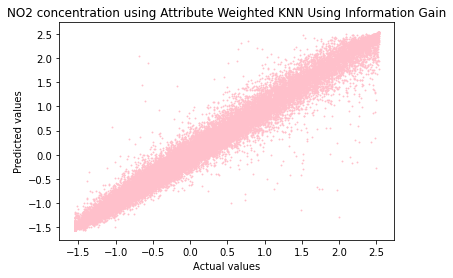

In [24]:
plt.scatter(testing_output, prediction, s = 0.75, c = 'pink')
plt.xlabel('Actual values')
plt.ylabel("Predicted values")
plt.title('NO2 concentration using Attribute Weighted KNN Using Information Gain')
plt.show()